# MLP
MLP, K=5, epochs=200.
Use lncRNA.

All transcripts per gene. Use GMM for threshold.

In [25]:
from datetime import datetime
print(datetime.now())

2023-04-04 14:53:38.016648


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.all_lncRNA_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [31]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 14:53:39.580020
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                65664     
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 14:53:40.087059
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 19789 sequences.
2023-04-04 14:54:40.110258

Training # 1 1
2023-04-04 14:54:40.111541
2023-04-04 14:54:40.111606
Discriminator is GMM
Means [-1.6758399311172867, 0.1319803166777027]
Variances [2.46099075 1.41731718]
Priors [0.49004469 0.50995531]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 8950:7109 55.73%
Computed class weights: {0: 1.1294837529891686, 1: 0.8971508379888268}
Valid 1:0 2347:1383 62.92%
FIT
2023-04-04 14:54:46.299920


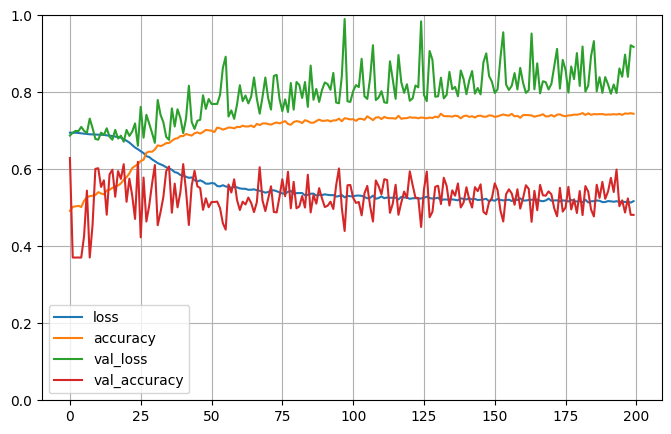


2023-04-04 14:59:09.184129

Testing # 1 1
2023-04-04 14:59:09.186240
2023-04-04 14:59:09.186586
PREDICT
2023-04-04 14:59:09.199607
Test 1:0 2347:1383 62.92%
Predict 1:0 1337:2393 35.84%
Test sizes (3730, 1025) (3730,)
Range of scores: 0.00023738731 to 0.9999853
Score threshold 0.5
Confusion matrix
 [[ 921  462]
 [1472  875]]
Normalized matrix
 [[0.24691689 0.12386059]
 [0.39463807 0.23458445]]


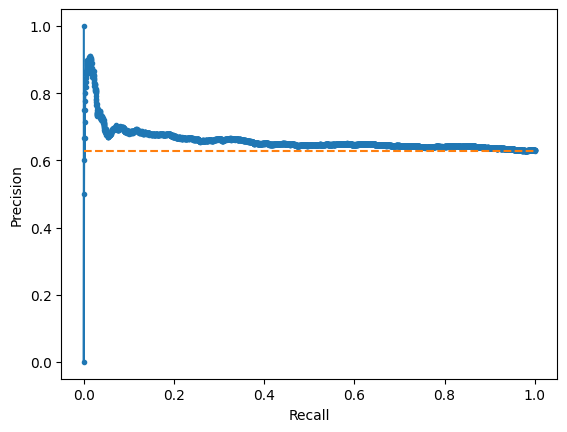

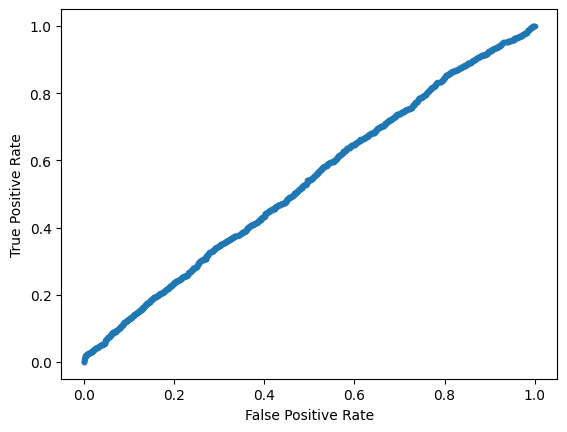

Accuracy: 48.15% Precision: 65.45% Recall: 37.28%
F1: 47.50% MCC: 0.0390
AUPRC: 65.94% AUROC: 53.35%
 accuracy [48.15013404825737]
 precision [65.44502617801047]
 recall [37.28163613123136]
 F1 [47.50271444082519]
 MCC [0.039040370139274125]
 AUPRC [65.94164318848766]
 AUROC [53.34811505341661]
2023-04-04 14:59:09.923670

Training # 1 2
2023-04-04 14:59:09.925236
2023-04-04 14:59:09.925517
Discriminator is GMM
Means [-0.03397415782309363, -1.826020454979901]
Variances [1.45934423 2.76217046]
Priors [0.58572998 0.41427002]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10877:4923 68.84%
Computed class weights: {0: 1.6047125736339631, 1: 0.7263032086053139}
Valid 1:0 2739:1250 68.66%
FIT
2023-04-04 14:59:16.904957


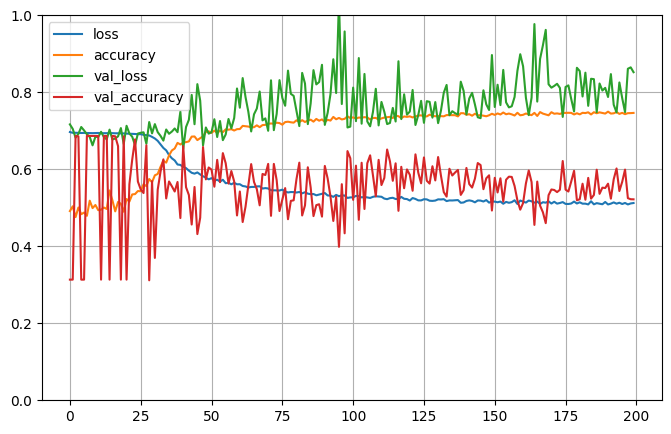


2023-04-04 15:02:58.910359

Testing # 1 2
2023-04-04 15:02:58.916324
2023-04-04 15:02:58.916371
PREDICT
2023-04-04 15:02:58.933100
Test 1:0 2739:1250 68.66%
Predict 1:0 1880:2109 47.13%
Test sizes (3989, 1025) (3989,)
Range of scores: 0.000292526 to 0.9929196
Score threshold 0.5
Confusion matrix
 [[ 726  524]
 [1383 1356]]
Normalized matrix
 [[0.1820005  0.13136124]
 [0.34670343 0.33993482]]


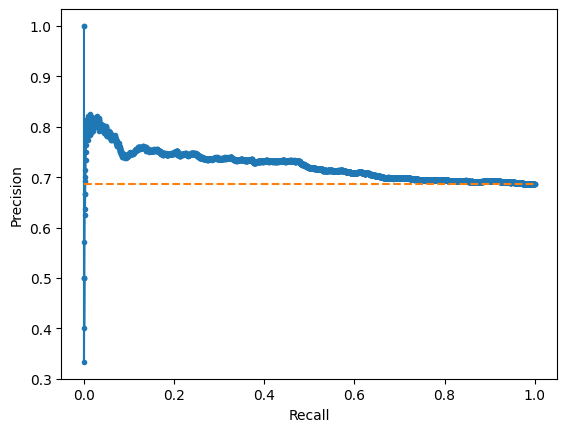

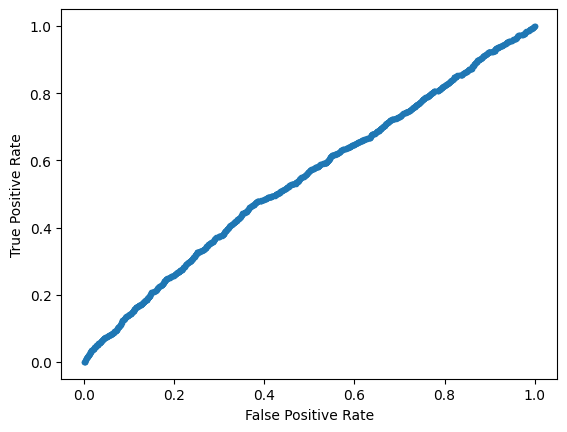

Accuracy: 52.19% Precision: 72.13% Recall: 49.51%
F1: 58.71% MCC: 0.0705
AUPRC: 72.27% AUROC: 54.50%
 accuracy [52.19353221358737]
 precision [72.12765957446808]
 recall [49.50711938663746]
 F1 [58.714007360900624]
 MCC [0.07050350793607839]
 AUPRC [72.26526231881816]
 AUROC [54.5009711573567]
2023-04-04 15:02:59.667983

Training # 1 3
2023-04-04 15:02:59.668643
2023-04-04 15:02:59.668704
Discriminator is GMM
Means [0.053831580061722305, -1.8006680083401607]
Variances [1.42148915 2.5060403 ]
Priors [0.56805585 0.43194415]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10604:5567 65.57%
Computed class weights: {0: 1.4523980599964075, 1: 0.7624952847981894}
Valid 1:0 2302:1316 63.63%
FIT
2023-04-04 15:03:04.459515


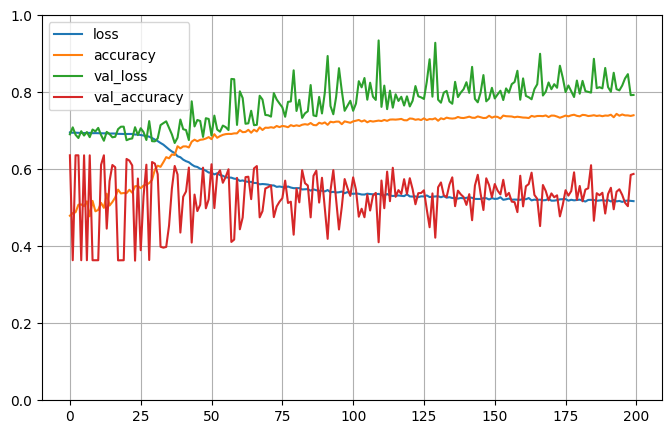


2023-04-04 15:07:27.300947

Testing # 1 3
2023-04-04 15:07:27.302560
2023-04-04 15:07:27.302597
PREDICT
2023-04-04 15:07:27.316719
Test 1:0 2302:1316 63.63%
Predict 1:0 2747:871 75.93%
Test sizes (3618, 1025) (3618,)
Range of scores: 0.004680507 to 0.9989047
Score threshold 0.5
Confusion matrix
 [[ 348  968]
 [ 523 1779]]
Normalized matrix
 [[0.09618574 0.26755113]
 [0.144555   0.49170813]]


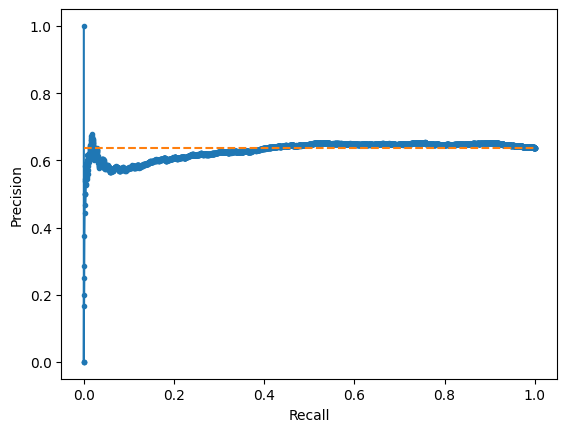

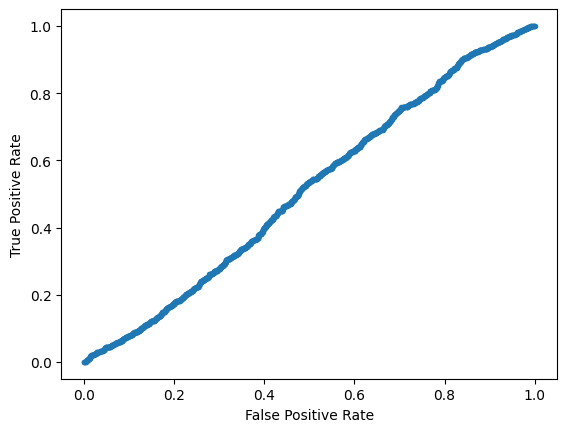

Accuracy: 58.79% Precision: 64.76% Recall: 77.28%
F1: 70.47% MCC: 0.0419
AUPRC: 63.03% AUROC: 51.19%
 accuracy [58.7893864013267]
 precision [64.76155806334182]
 recall [77.28062554300608]
 F1 [70.46939988116459]
 MCC [0.04190809100865248]
 AUPRC [63.02661567961678]
 AUROC [51.194481341716866]
2023-04-04 15:07:27.906350

Training # 1 4
2023-04-04 15:07:27.907368
2023-04-04 15:07:27.907428
Discriminator is GMM
Means [-1.8741662760461324, 0.006516733898399464]
Variances [2.56395909 1.370483  ]
Priors [0.42766015 0.57233985]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10387:5526 65.27%
Computed class weights: {0: 1.4398298950416215, 1: 0.7660055839029556}
Valid 1:0 2737:1139 70.61%
FIT
2023-04-04 15:07:34.823956


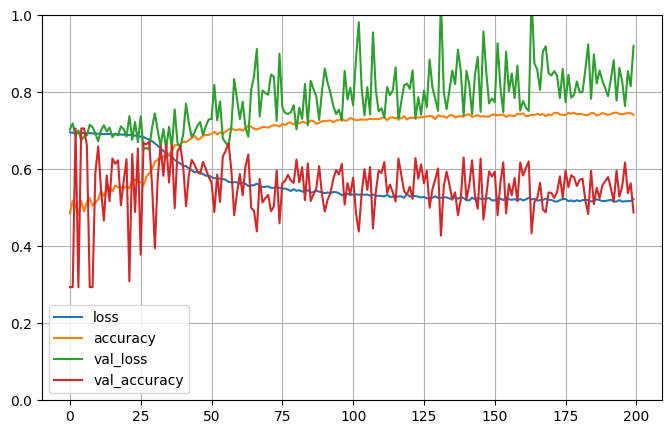


2023-04-04 15:11:17.100086

Testing # 1 4
2023-04-04 15:11:17.101107
2023-04-04 15:11:17.101140
PREDICT
2023-04-04 15:11:17.114708
Test 1:0 2737:1139 70.61%
Predict 1:0 1606:2270 41.43%
Test sizes (3876, 1025) (3876,)
Range of scores: 0.0010447348 to 0.9979962
Score threshold 0.5
Confusion matrix
 [[ 712  427]
 [1558 1179]]
Normalized matrix
 [[0.18369453 0.11016512]
 [0.40196078 0.30417957]]


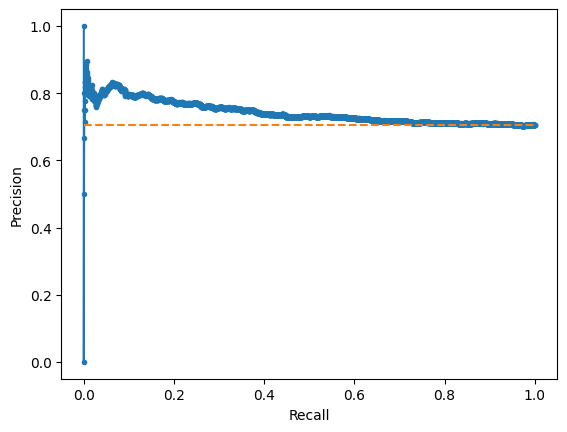

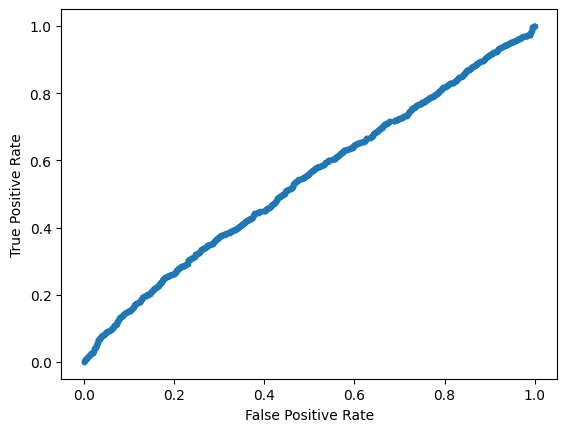

Accuracy: 48.79% Precision: 73.41% Recall: 43.08%
F1: 54.29% MCC: 0.0517
AUPRC: 74.19% AUROC: 54.08%
 accuracy [48.78740970072239]
 precision [73.41220423412204]
 recall [43.076360979174275]
 F1 [54.294266635965926]
 MCC [0.05166760290363591]
 AUPRC [74.19130179109797]
 AUROC [54.08260872772974]
2023-04-04 15:11:17.866444

Training # 1 5
2023-04-04 15:11:17.867561
2023-04-04 15:11:17.868465
Discriminator is GMM
Means [0.024018451612978452, -1.9649463605484332]
Variances [1.36245906 2.32069659]
Priors [0.627736 0.372264]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10819:4394 71.12%
Computed class weights: {0: 1.7311106053709604, 1: 0.7030686754783252}
Valid 1:0 3079:1497 67.29%
FIT
2023-04-04 15:11:23.753800


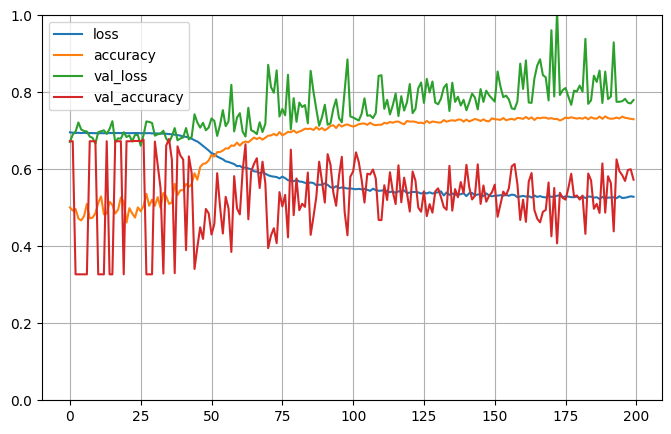


2023-04-04 15:14:57.963226

Testing # 1 5
2023-04-04 15:14:57.963563
2023-04-04 15:14:57.963613
PREDICT
2023-04-04 15:14:57.984788
Test 1:0 3079:1497 67.29%
Predict 1:0 3303:1273 72.18%
Test sizes (4576, 1025) (4576,)
Range of scores: 0.0021017944 to 0.9980833
Score threshold 0.5
Confusion matrix
 [[ 408 1089]
 [ 865 2214]]
Normalized matrix
 [[0.08916084 0.23798077]
 [0.18902972 0.48382867]]


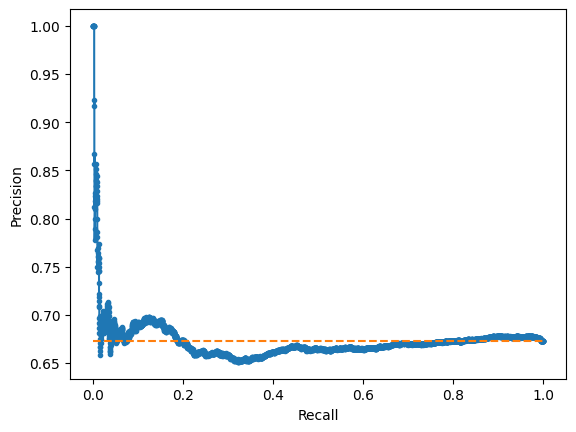

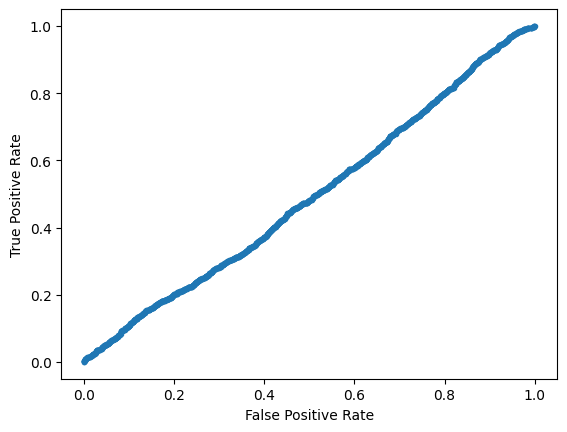

Accuracy: 57.30% Precision: 67.03% Recall: 71.91%
F1: 69.38% MCC: -0.0088
AUPRC: 67.33% AUROC: 49.37%
 accuracy [57.298951048951054]
 precision [67.0299727520436]
 recall [71.90646313738227]
 F1 [69.38263867126292]
 MCC [-0.008784633148766761]
 AUPRC [67.33201303910177]
 AUROC [49.37166744444828]
2023-04-04 15:14:58.754991

Training # 2 1
2023-04-04 15:14:58.756473
2023-04-04 15:14:58.757100
Discriminator is GMM
Means [0.0004667154092980761, -1.8769591293440053]
Variances [1.46818621 2.67186048]
Priors [0.58381778 0.41618222]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10317:5031 67.22%
Computed class weights: {0: 1.5253428741800834, 1: 0.7438208781622565}
Valid 1:0 3154:1287 71.02%
FIT
2023-04-04 15:15:03.671410


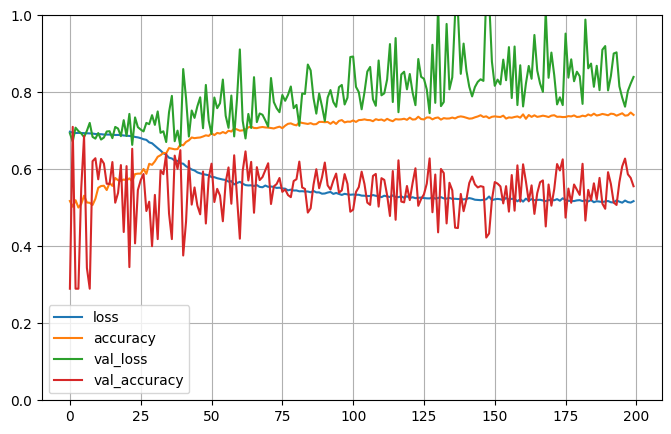


2023-04-04 15:19:26.928262

Testing # 2 1
2023-04-04 15:19:26.928403
2023-04-04 15:19:26.928460
PREDICT
2023-04-04 15:19:26.945586
Test 1:0 3154:1287 71.02%
Predict 1:0 2528:1913 56.92%
Test sizes (4441, 1025) (4441,)
Range of scores: 0.000776263 to 0.99886405
Score threshold 0.5
Confusion matrix
 [[ 614  673]
 [1299 1855]]
Normalized matrix
 [[0.13825715 0.15154245]
 [0.29250169 0.41769872]]


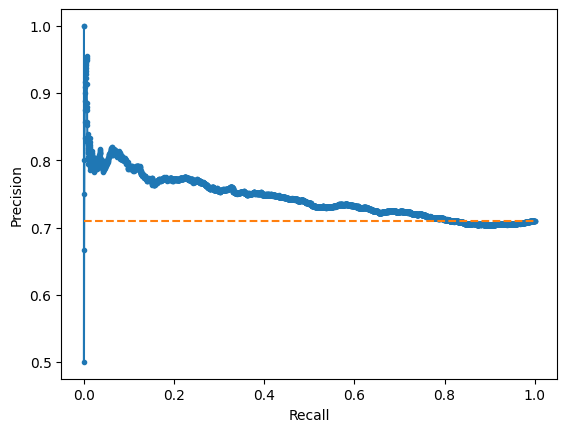

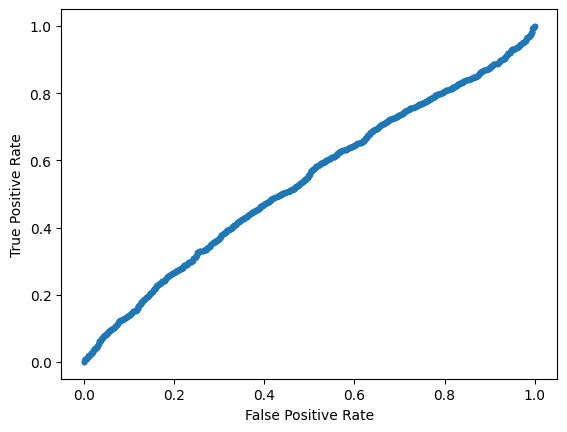

Accuracy: 55.60% Precision: 73.38% Recall: 58.81%
F1: 65.29% MCC: 0.0598
AUPRC: 74.38% AUROC: 53.66%
 accuracy [55.595586579599185]
 precision [73.37816455696202]
 recall [58.8142041851617]
 F1 [65.29391059486096]
 MCC [0.05975281198086175]
 AUPRC [74.38176099034806]
 AUROC [53.655672869369766]
2023-04-04 15:19:27.596755

Training # 2 2
2023-04-04 15:19:27.597732
2023-04-04 15:19:27.597789
Discriminator is GMM
Means [0.06565424729214618, -1.797417641192013]
Variances [1.34439582 2.546908  ]
Priors [0.5758194 0.4241806]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10264:5437 65.37%
Computed class weights: {0: 1.4439028876218503, 1: 0.7648577552611068}
Valid 1:0 2690:1398 65.80%
FIT
2023-04-04 15:19:36.801330


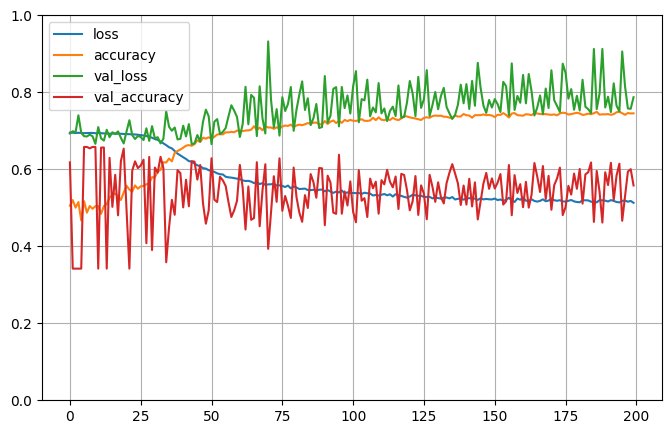


2023-04-04 15:23:18.651999

Testing # 2 2
2023-04-04 15:23:18.654557
2023-04-04 15:23:18.654817
PREDICT
2023-04-04 15:23:18.669272
Test 1:0 2690:1398 65.80%
Predict 1:0 2355:1733 57.61%
Test sizes (4088, 1025) (4088,)
Range of scores: 0.00091566355 to 0.99920213
Score threshold 0.5
Confusion matrix
 [[ 662  736]
 [1071 1619]]
Normalized matrix
 [[0.16193738 0.18003914]
 [0.2619863  0.39603718]]


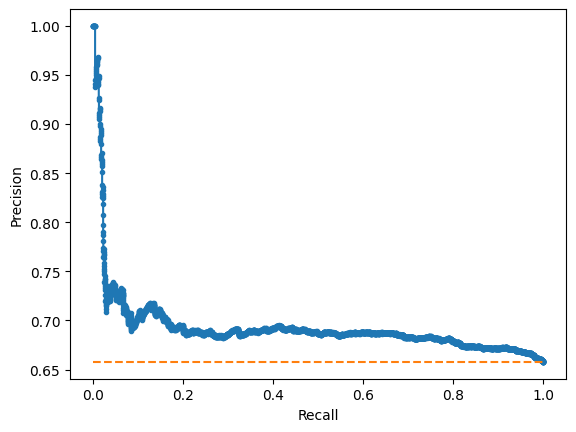

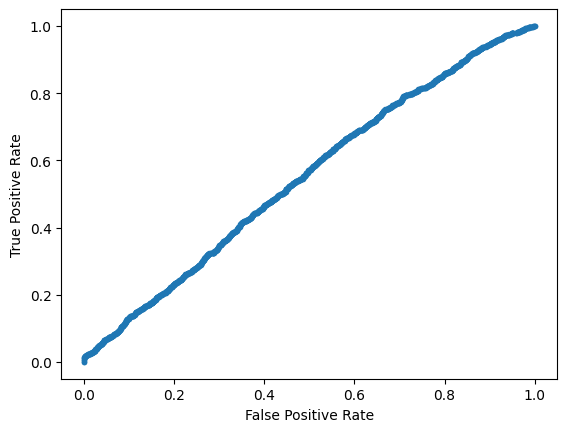

Accuracy: 55.80% Precision: 68.75% Recall: 60.19%
F1: 64.18% MCC: 0.0724
AUPRC: 69.34% AUROC: 54.97%
 accuracy [55.797455968688844]
 precision [68.74734607218683]
 recall [60.18587360594796]
 F1 [64.18235877106045]
 MCC [0.07237062129016202]
 AUPRC [69.34280673817904]
 AUROC [54.96715967047987]
2023-04-04 15:23:19.458496

Training # 2 3
2023-04-04 15:23:19.458671
2023-04-04 15:23:19.460482
Discriminator is GMM
Means [-1.7440377148623039, 0.22989711327670082]
Variances [2.02126817 1.29042425]
Priors [0.47311587 0.52688413]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 9032:6979 56.41%
Computed class weights: {0: 1.147084109471271, 1: 0.8863485385296723}
Valid 1:0 2090:1688 55.32%
FIT
2023-04-04 15:23:24.076503


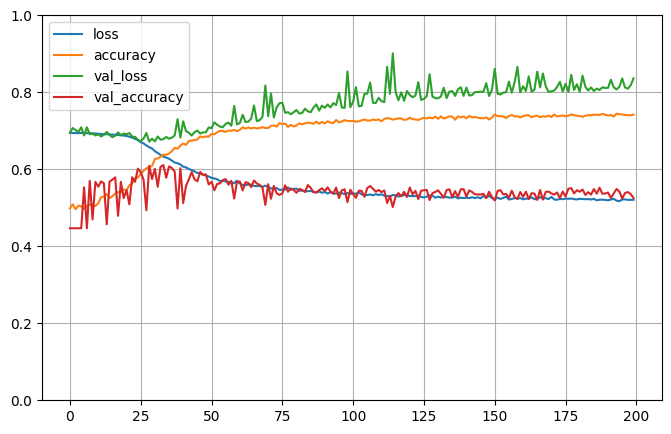


2023-04-04 15:27:08.663096

Testing # 2 3
2023-04-04 15:27:08.664091
2023-04-04 15:27:08.664125
PREDICT
2023-04-04 15:27:08.678823
Test 1:0 2090:1688 55.32%
Predict 1:0 1575:2203 41.69%
Test sizes (3778, 1025) (3778,)
Range of scores: 0.0011870939 to 0.9965989
Score threshold 0.5
Confusion matrix
 [[1049  639]
 [1154  936]]
Normalized matrix
 [[0.27766014 0.16913711]
 [0.30545262 0.24775013]]


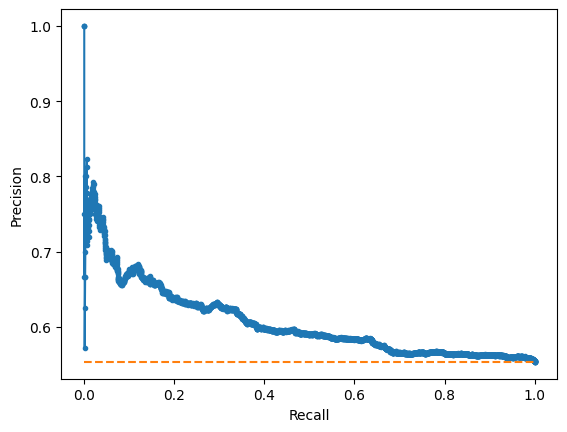

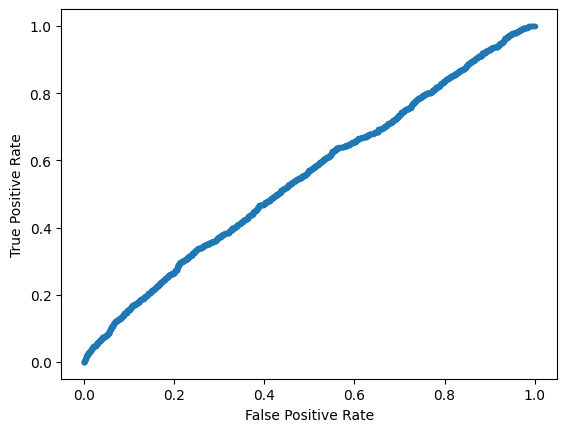

Accuracy: 52.54% Precision: 59.43% Recall: 44.78%
F1: 51.08% MCC: 0.0699
AUPRC: 60.61% AUROC: 55.09%
 accuracy [52.54102699841185]
 precision [59.42857142857143]
 recall [44.78468899521531]
 F1 [51.07776261937245]
 MCC [0.06987106491981403]
 AUPRC [60.60713185420564]
 AUROC [55.09025147962539]
2023-04-04 15:27:09.451713

Training # 2 4
2023-04-04 15:27:09.451869
2023-04-04 15:27:09.451914
Discriminator is GMM
Means [-0.03389314433770613, -1.8457535357861536]
Variances [1.40824418 2.81492043]
Priors [0.60060276 0.39939724]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 11609:4618 71.54%
Computed class weights: {0: 1.756929406669554, 1: 0.6988974071840813}
Valid 1:0 2434:1128 68.33%
FIT
2023-04-04 15:27:14.376995


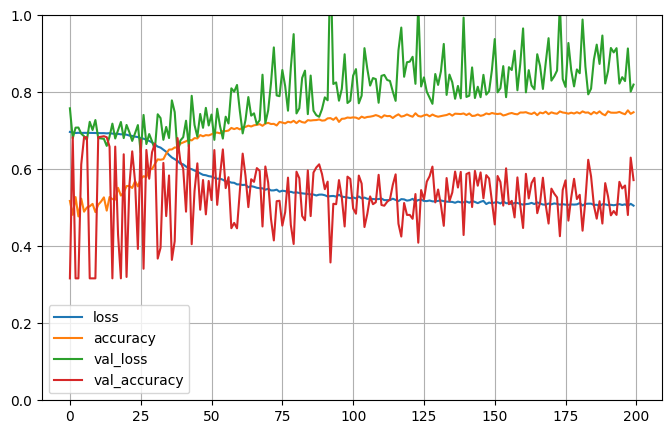


2023-04-04 15:31:37.525883

Testing # 2 4
2023-04-04 15:31:37.527018
2023-04-04 15:31:37.527295
PREDICT
2023-04-04 15:31:37.539373
Test 1:0 2434:1128 68.33%
Predict 1:0 2357:1205 66.17%
Test sizes (3562, 1025) (3562,)
Range of scores: 0.0031027177 to 0.9985224
Score threshold 0.5
Confusion matrix
 [[ 404  724]
 [ 801 1633]]
Normalized matrix
 [[0.11341943 0.2032566 ]
 [0.22487367 0.45845031]]


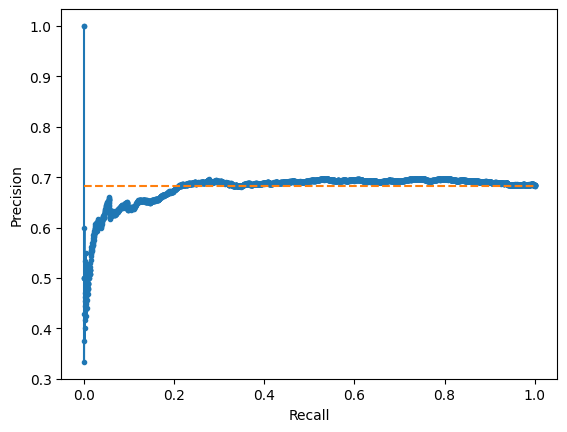

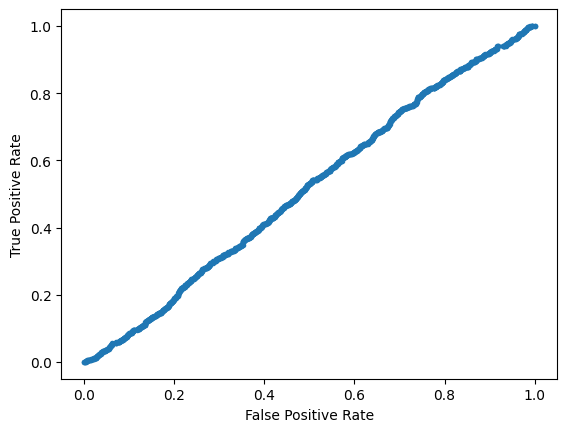

Accuracy: 57.19% Precision: 69.28% Recall: 67.09%
F1: 68.17% MCC: 0.0286
AUPRC: 67.84% AUROC: 51.33%
 accuracy [57.18697361033127]
 precision [69.28298684768774]
 recall [67.0912078882498]
 F1 [68.16948445001043]
 MCC [0.028579740160022012]
 AUPRC [67.8429529082916]
 AUROC [51.32589002138732]
2023-04-04 15:31:38.494193

Training # 2 5
2023-04-04 15:31:38.495446
2023-04-04 15:31:38.495515
Discriminator is GMM
Means [-0.07278927654138478, -1.8356883998549485]
Variances [1.49474544 2.66546851]
Priors [0.57216767 0.42783233]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 10665:5204 67.21%
Computed class weights: {0: 1.5246925441967718, 1: 0.7439756211908111}
Valid 1:0 2838:1082 72.40%
FIT
2023-04-04 15:31:43.702920


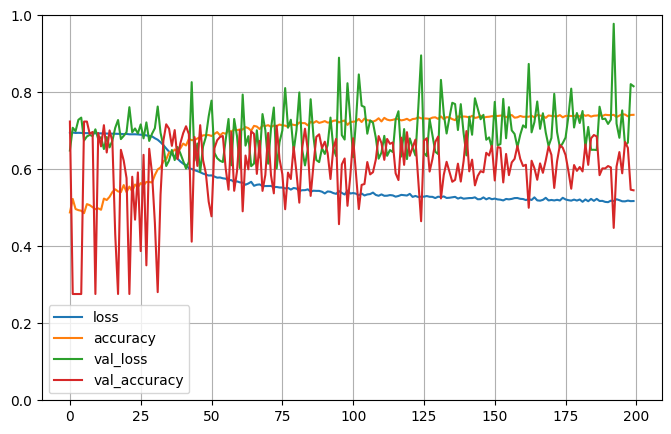


2023-04-04 15:36:06.552968

Testing # 2 5
2023-04-04 15:36:06.554237
2023-04-04 15:36:06.554285
PREDICT
2023-04-04 15:36:06.569141
Test 1:0 2838:1082 72.40%
Predict 1:0 1712:2208 43.67%
Test sizes (3920, 1025) (3920,)
Range of scores: 0.0008642219 to 0.99999994
Score threshold 0.5
Confusion matrix
 [[ 754  328]
 [1454 1384]]
Normalized matrix
 [[0.19234694 0.08367347]
 [0.37091837 0.35306122]]


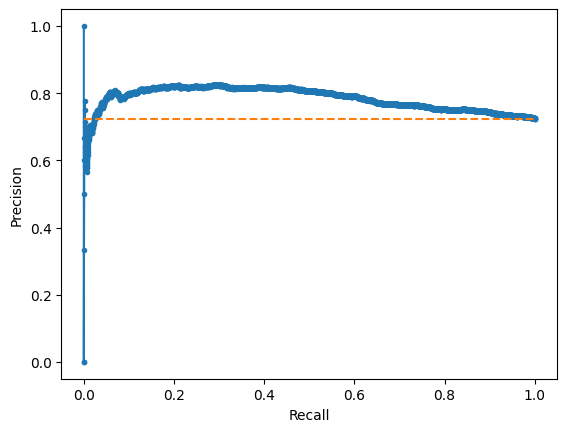

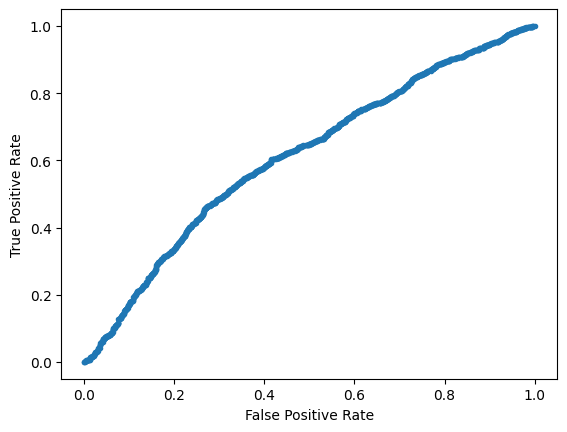

Accuracy: 54.54% Precision: 80.84% Recall: 48.77%
F1: 60.84% MCC: 0.1663
AUPRC: 78.28% AUROC: 61.13%
 accuracy [54.54081632653062]
 precision [80.8411214953271]
 recall [48.766737138830166]
 F1 [60.835164835164846]
 MCC [0.16631205312517094]
 AUPRC [78.28439801954367]
 AUROC [61.13043342334491]
2023-04-04 15:36:07.281404


In [35]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [36]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.09% std 3.60
 precision mean 69.45% std 5.90
 recall mean 55.87% std 13.30
 F1 mean 60.99% std 7.96
 MCC mean 0.06% std 0.04
 AUPRC mean 69.32% std 5.49
 AUROC mean 53.87% std 3.16
 accuracy [[48.15013404825737], [52.19353221358737], [58.7893864013267], [48.78740970072239], [57.298951048951054], [55.595586579599185], [55.797455968688844], [52.54102699841185], [57.18697361033127], [54.54081632653062]]
 precision [[65.44502617801047], [72.12765957446808], [64.76155806334182], [73.41220423412204], [67.0299727520436], [73.37816455696202], [68.74734607218683], [59.42857142857143], [69.28298684768774], [80.8411214953271]]
 recall [[37.28163613123136], [49.50711938663746], [77.28062554300608], [43.076360979174275], [71.90646313738227], [58.8142041851617], [60.18587360594796], [44.78468899521531], [67.0912078882498], [48.766737138830166]]
 F1 [[47.50271444082519], [58.714007360900624], [70.46939988116459], [54.294266635965926], [69.38263867126292], [65.29391059486096], [64.18